### Data pre-processing steps

In [18]:
# Code from this link:
# https://github.com/CornellNLP/ConvoKit/blob/master/datasets/winning-args-corpus/stats.ipynb

try:
  import convokit
except ModuleNotFoundError:
  !pip install convokit
import os
import convokit
from convokit import Corpus, PolitenessStrategies, download
import timeit
import re
from numpy import mean
from scipy import stats
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import precision_recall_fscore_support
import math
import pickle
import matplotlib.pyplot as plt
from google.colab import files


In [2]:
corpus = Corpus(download("winning-args-corpus"))
utterance_ids = corpus.get_utterance_ids()

In [3]:
len(utterance_ids)

293297

In [4]:
u = 0
s = 0
for each in utterance_ids:
    if corpus.get_utterance(each).meta["success"] == 0:
        u = u + 1
    if corpus.get_utterance(each).meta["success"] == 1:
        s = s + 1
print("number of comments that are part of a successful thread: " + str(s))
print("number of comments that are part of an unsuccessful thread: " + str(u))

number of comments that are part of a successful thread: 12420
number of comments that are part of an unsuccessful thread: 7294


Something important to note: according to documentation provided [here](https://convokit.cornell.edu/documentation/winning.html), there are few fewer comments that are either successful or unsuccessful than the total number of utterances because the vast majority of utterances are comments that have a meta["success"] value of None. The original authors that created the r/changemyview dataset compared successful comments (comments that were awarded deltas) with comments that were similar in nature, but unsuccessful (comments that were not not awarded deltas). These comments were given meta["success"] labels of 1 or 0, respectively. Every other comment that wasn't awarded a delta was given a meta["success"] label of None, because those comments weren't similar enough to successful comments to be meaningfully compared.

In [5]:
# we want the original post made by op, the challenger's comments and all of OP's responses to the challengers
# these three lists are utterance ids for the original post, challenger comments and op replies respectively

opPost = []
challengerPos = []
challengerNeg = []
opReplyPos = []
opReplyNeg = []
for iD in utterance_ids:
    if corpus.get_utterance(iD).id == corpus.get_utterance(iD).root:
        opPost.append(iD)
    if (
        corpus.get_utterance(iD).speaker.id
        != corpus.get_utterance(corpus.get_utterance(iD).root).speaker.id
        and corpus.get_utterance(iD).meta["success"] == 0
    ):
        challengerNeg.append(iD)

    if (
        corpus.get_utterance(iD).speaker.id
        != corpus.get_utterance(corpus.get_utterance(iD).root).speaker.id
        and corpus.get_utterance(iD).meta["success"] == 1
    ):
        challengerPos.append(iD)

    if (
        corpus.get_utterance(iD).id != corpus.get_utterance(iD).root
        and corpus.get_utterance(iD).speaker.id
        == corpus.get_utterance(corpus.get_utterance(iD).root).speaker.id
        and corpus.get_utterance(iD).meta["success"] == 0
    ):
        opReplyNeg.append(iD)
    if (
        corpus.get_utterance(iD).id != corpus.get_utterance(iD).root
        and corpus.get_utterance(iD).speaker.id
        == corpus.get_utterance(corpus.get_utterance(iD).root).speaker.id
        and corpus.get_utterance(iD).meta["success"] == 1
    ):
        opReplyPos.append(iD)


<ipython-input-5-533eed2793a8>:10: FutureWarning: utterance.root is deprecated and will be removed in a future release. Use utterance.conversation_id instead.
<ipython-input-5-533eed2793a8>:14: FutureWarning: utterance.root is deprecated and will be removed in a future release. Use utterance.conversation_id instead.
<ipython-input-5-533eed2793a8>:21: FutureWarning: utterance.root is deprecated and will be removed in a future release. Use utterance.conversation_id instead.
<ipython-input-5-533eed2793a8>:27: FutureWarning: utterance.root is deprecated and will be removed in a future release. Use utterance.conversation_id instead.
<ipython-input-5-533eed2793a8>:34: FutureWarning: utterance.root is deprecated and will be removed in a future release. Use utterance.conversation_id instead.
<ipython-input-5-533eed2793a8>:29: FutureWarning: utterance.root is deprecated and will be removed in a future release. Use utterance.conversation_id instead.
<ipython-input-5-533eed2793a8>:36: FutureWarni

In [6]:
# collect utterance dict given the subset of ids
subset = opPost + challengerPos + challengerNeg + opReplyPos + opReplyNeg
utterance_list = []
for iD in subset:
    utterance_list.append(corpus.get_utterance(iD))

In [7]:
# this subset separates OP comments and challenger utterances from all other comments in every conversation (thread)
corpus = convokit.Corpus(utterances=utterance_list)
corpus.print_summary_stats()

Number of Speakers: 6210
Number of Utterances: 22765
Number of Conversations: 3051


In [8]:
utts = list(corpus.iter_utterances())  # list of all uterrance objects in the corpus
len(utts)

22765

### Get sentiment and emotion of posts and replies

We use a fine-tuned version of the DistilRoBERTa-base transformer model on Hugging Face to classify the emotion each post and reply from r/changemyview in 7 different categories: anger, disgust, fear, joy, neutral, sadness, and surprise.

In [9]:
# classify the emotions across 7 categories for each post and reply: anger, disgust, fear, joy, neutral, sadness, and surprise
try:
  import transformers
except ModuleNotFoundError:
  !pip install transformers
from transformers import pipeline
# longer texts than 512 tokens are truncated; this is unfortunate, but unavoidable,
# as the model cannot handle longer texts
emotion_classifier = pipeline("text-classification", model='j-hartmann/emotion-english-distilroberta-base', max_length=512, truncation=True, return_all_scores=True)
prediction = emotion_classifier(utts[0].text)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [10]:
utts[1].text

"My wife has recently gotten deeply involved/obsessed with the healing properties of essential oils.  I am cursed with a common problem in that I am an extremely skeptical person.  I can't help but look at this product and see a pyramid scheme that takes advantage of the gullible.  All the shit my wife watches on these oils is carefully worded to make sure they don't make actual healing claims, I'm told this is because they aren't FDA approved and could get in trouble.  I've looked a little and haven't found anything debunking these oils but i still cannot help but feel they are total BS.  I would love to get more information from unbiased sources on this.  \n\nPlease change my view without just anecdotal testimonies. "

In [11]:
prediction = emotion_classifier(utts[1].text)
prediction

[[{'label': 'anger', 'score': 0.07173146307468414},
  {'label': 'disgust', 'score': 0.07884222269058228},
  {'label': 'fear', 'score': 0.6088862419128418},
  {'label': 'joy', 'score': 0.0038501934614032507},
  {'label': 'neutral', 'score': 0.14825265109539032},
  {'label': 'sadness', 'score': 0.07804114371538162},
  {'label': 'surprise', 'score': 0.010396122932434082}]]

We use a RoBERTa-base transformer model from Hugging Face, trained on ~124 tweets and fine-tuned for sentiment analysis, to classify the sentiment of each post and reply from the r/changemyview dataset. The sentiment can be either positive, neutral, or negative, and a score from 0 to 1 indicating the strenght of the sentiment is also given for each utterance.

In [12]:
# classify the sentiment for each post and reply as one of 3 options: positive,
# neutral, or negative

# longer texts than 512 tokens are truncated; this is unfortunate, but unavoidable,
# as the model cannot handle longer texts
sentiment_classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest", max_length=512, truncation=True)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
sentiment_classifier(utts[1].text)

[{'label': 'negative', 'score': 0.8590196967124939}]

### Loop through all the original posts and replies, classifying the emotion and sentiment of each.

In [14]:
# get all op objects in a list
ops = []
for opID in opPost:
  ops.append(corpus.get_utterance(opID))

# get all reply objects in a list
replyIDs = challengerPos + challengerNeg
replies = []
for replyID in replyIDs:
  replies.append(corpus.get_utterance(replyID))

# get all op replies to replies in a list
opReplyIDs = opReplyPos + opReplyNeg
op_replies = []
for opReplyID in opReplyIDs:
  op_replies.append(corpus.get_utterance(opReplyID))

print(len(ops), len(replies), len(op_replies))

3051 11020 8694


### Initialize dictionaries to store the emotion and sentiment of all the utterances

In [15]:
# find the emotion and sentiment of each original post (op), reply, and op reply to the reply
# the keys of each of these dictionaries are the utterance ids, and the values are the utterance objects
reply_emotions = {}
reply_sentiments = {}
op_emotions = {}
op_sentiments = {}
op_reply_emotions = {}
op_reply_sentiments = {}

### Run the three code blocks below if you haven't gotten the sentiment and emotions for the utterances yet; otherwise, skip these

In [ ]:
i = 0
for reply in replies:
  i += 1
  if i % 1000 == 0:
    print(i)
  emotions = emotion_classifier(reply.text)
  sentiment = sentiment_classifier(reply.text)
  reply_emotions[reply.id] = emotions[0]
  reply_sentiments[reply.id] = sentiment[0]

# save the emotion and sentiment dictionaries to pickle files
with open('reply_emotions.pkl', 'wb') as f:
  pickle.dump(reply_emotions, f)
f.close()
with open('reply_sentiments.pkl', 'wb') as f:
  pickle.dump(reply_sentiments, f)
f.close()

#download the pkl files so we don't lose them if google colab crashes
files.download('reply_emotions.pkl') 
files.download('reply_sentiments.pkl')

1000
2000


In [ ]:
i = 0
for op in ops:
  i += 1
  if i % 1000 == 0:
    print(i)
  emotions = emotion_classifier(op.text)
  sentiment = sentiment_classifier(op.text)
  op_emotions[op.id] = emotions[0]
  op_sentiments[op.id] = sentiment[0]

# save the emotion and sentiment dictionaries to pickle files
with open('op_emotions.pkl', 'wb') as f:
  pickle.dump(op_emotions, f)
f.close()
with open('op_sentiments.pkl', 'wb') as f:
  pickle.dump(op_sentiments, f)
f.close()

#download the pkl files so we don't lose them if google colab crashes
files.download('op_emotions.pkl') 
files.download('op_sentiments.pkl')

1000
2000
3000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
i = 0
for op_reply in op_replies:
  i += 1
  if i % 1000 == 0:
    print(i)
  emotions = emotion_classifier(op_reply.text)
  sentiment = sentiment_classifier(op_reply.text)
  op_reply_emotions[op_reply.id] = emotions[0]
  op_reply_sentiments[op_reply.id] = sentiment[0]

# save the emotion and sentiment dictionaries to pickle files
with open('op_reply_emotions.pkl', 'wb') as f:
  pickle.dump(op_reply_emotions, f)
f.close()
with open('op_reply_sentiments.pkl', 'wb') as f:
  pickle.dump(op_reply_sentiments, f)
f.close()

#download the pkl files so we don't lose them if google colab crashes
files.download('op_reply_emotions.pkl') 
files.download('op_reply_sentiments.pkl')

1000
2000
3000
4000
5000
6000
7000
8000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Run the code block below if you already have the files that have the data for the sentiment and emotions; otherwise, skip this

In [16]:
# load the emotion and sentiment of each original post (op), reply, and op reply to the reply
with open('reply_emotions.pkl', 'rb') as f:
  reply_emotions = pickle.load(f)
f.close()

with open('reply_sentiments.pkl', 'rb') as f:
  reply_sentiments = pickle.load(f)
f.close()

with open('op_emotions.pkl', 'rb') as f:
  op_emotions = pickle.load(f)
f.close()

with open('op_sentiments.pkl', 'rb') as f:
  op_sentiments = pickle.load(f)
f.close()

with open('op_reply_emotions.pkl', 'rb') as f:
  op_reply_emotions = pickle.load(f)
f.close()

with open('op_reply_sentiments.pkl', 'rb') as f:
  op_reply_sentiments = pickle.load(f)
f.close()


In [17]:
# test whether the emotion and sentiment dictionaries were loaded successfully
print(reply_emotions[random.choice(replies).id])
print(reply_sentiments[random.choice(replies).id])
print(op_emotions[random.choice(ops).id])
print(op_sentiments[random.choice(ops).id])
print(op_reply_emotions[random.choice(op_replies).id])
print(op_reply_sentiments[random.choice(op_replies).id])


[{'label': 'anger', 'score': 0.11625105887651443}, {'label': 'disgust', 'score': 0.3047790825366974}, {'label': 'fear', 'score': 0.03872518986463547}, {'label': 'joy', 'score': 0.002464813645929098}, {'label': 'neutral', 'score': 0.2758316397666931}, {'label': 'sadness', 'score': 0.25641682744026184}, {'label': 'surprise', 'score': 0.005531440023332834}]
{'label': 'neutral', 'score': 0.5743670463562012}
[{'label': 'anger', 'score': 0.03406111150979996}, {'label': 'disgust', 'score': 0.6202121376991272}, {'label': 'fear', 'score': 0.004776827525347471}, {'label': 'joy', 'score': 0.003073676722124219}, {'label': 'neutral', 'score': 0.2964757978916168}, {'label': 'sadness', 'score': 0.0322958379983902}, {'label': 'surprise', 'score': 0.00910455547273159}]
{'label': 'positive', 'score': 0.5402793288230896}
[{'label': 'anger', 'score': 0.4282609820365906}, {'label': 'disgust', 'score': 0.39906275272369385}, {'label': 'fear', 'score': 0.07384254783391953}, {'label': 'joy', 'score': 0.0010070

### Find the average emotion and sentiment for original posts

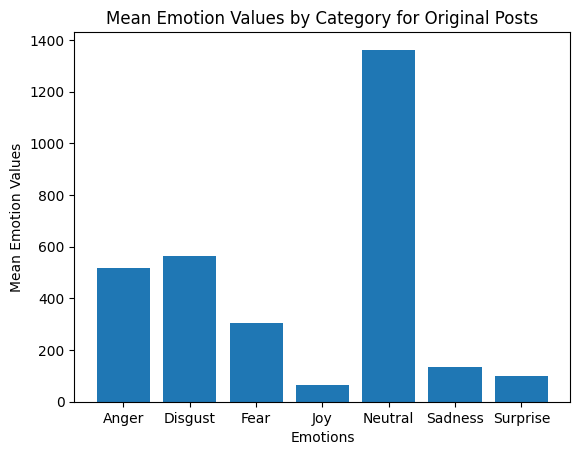

In [25]:
# each variable below has the mean emotion of original posts for each category
mean_anger = 0
mean_disgust = 0
mean_fear = 0
mean_joy = 0
mean_neutral = 0
mean_sadness = 0
mean_surprise = 0

mean_emotions = [mean_anger, mean_disgust, mean_fear, mean_joy, mean_neutral, mean_sadness, mean_surprise]
emotions = ['Anger', 'Disgust', 'Fear', 'Joy', 'Neutral', 'Sadness', 'Surprise']

# get the sum of the emotion scores for each original post
for op in ops:
  for i in range(len(mean_emotions)):
    mean_emotions[i] += op_emotions[op.id][i]['score']

# divide by the total number of original posts to find the mean
for mean_emotion in mean_emotions:
  mean_emotion /= len(ops)

# data visualizations using the mean emotions
plt.bar(emotions, mean_emotions)
plt.xlabel('Emotions')
plt.ylabel('Mean Emotion Values')
plt.title('Mean Emotion Values by Category for Original Posts')
plt.show()

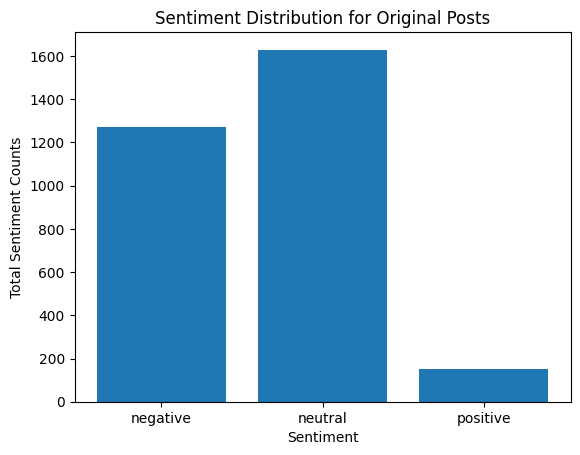

In [21]:
# find the sentiment distribution for original posts

sentiment_counts = [0, 0, 0]
for op in ops:
  if op_sentiments[op.id]['label'] == 'negative':
    sentiment_counts[0] += 1
  elif op_sentiments[op.id]['label'] == 'neutral':
    sentiment_counts[1] += 1
  else:
    sentiment_counts[2] += 1

sentiments = ['negative', 'neutral', 'positive']

# data visualizations using the sentiment counts
plt.bar(sentiments, sentiment_counts)
plt.xlabel('Sentiment')
plt.ylabel('Total Sentiment Counts')
plt.title('Sentiment Distribution for Original Posts')
plt.show()

### Find the average emotion and sentiment for successful and unsuccessful replies

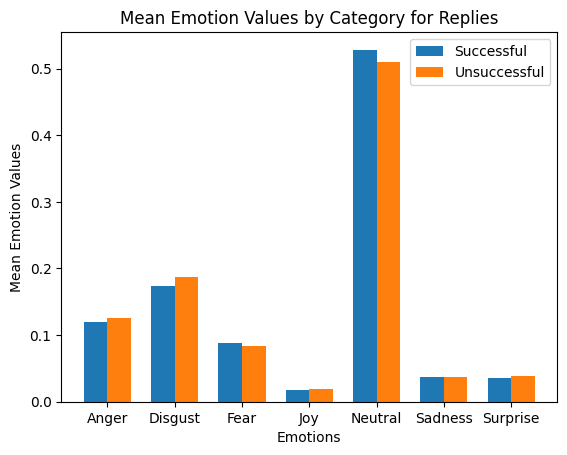

In [26]:
# each variable below is a dictionary that will have "successful" and "unsuccessful"
# keys, each with the mean emotion for each category of replies as the value
mean_anger = {}
mean_disgust = {}
mean_fear = {}
mean_joy = {}
mean_neutral = {}
mean_sadness = {}
mean_surprise = {}

mean_emotions = [mean_anger, mean_disgust, mean_fear, mean_joy, mean_neutral, mean_sadness, mean_surprise]

# get the sum of the emotion scores for both successful and unsuccessful replies
num_success = 0
num_unsuccess = 0
for reply in replies:
  if reply.meta['success']:
    num_success += 1
    for i in range(len(mean_emotions)):
      mean_emotions[i]['successful'] = mean_emotions[i].get('successful', 0) + reply_emotions[reply.id][i]['score']
  else:
    num_unsuccess += 1
    for i in range(len(mean_emotions)):
      mean_emotions[i]['unsuccessful'] = mean_emotions[i].get('unsuccessful', 0) + reply_emotions[reply.id][i]['score']

# divide by the total number of successful and unsuccessful replies to find 
# the mean of each emotion
for mean_emotion in mean_emotions:
  mean_emotion['successful'] /= num_success
  mean_emotion['unsuccessful'] /= num_unsuccess

# data visualizations using the mean emotions
emotions = ['Anger', 'Disgust', 'Fear', 'Joy', 'Neutral', 'Sadness', 'Surprise']
categories = ['successful', 'unsuccessful']

# Extract mean emotion values for each category
successful_values = [mean_emotion['successful'] for mean_emotion in mean_emotions]
unsuccessful_values = [mean_emotion['unsuccessful'] for mean_emotion in mean_emotions]

# Set the positions of the bars on the x-axis
bar_width = 0.35
index = np.arange(len(emotions))

# Plot the bar graph
plt.bar(index, successful_values, bar_width, label='Successful')
plt.bar(index + bar_width, unsuccessful_values, bar_width, label='Unsuccessful')

# Customize the graph
plt.xlabel('Emotions')
plt.ylabel('Mean Emotion Values')
plt.title('Mean Emotion Values by Category for Replies')
plt.xticks(index + bar_width/2, emotions)
plt.legend()

plt.show()

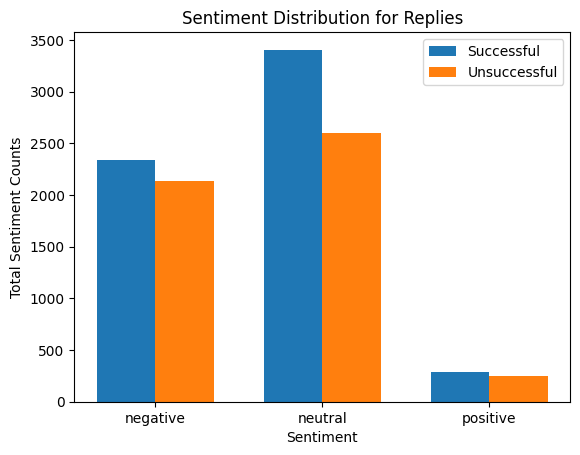

In [30]:
# find the sentiment distribution for replies

successful_sentiment_counts = [0, 0, 0]
unsuccessful_sentiment_counts = [0, 0, 0]
for reply in replies:
  if reply.meta['success']:
    if reply_sentiments[reply.id]['label'] == 'negative':
      successful_sentiment_counts[0] += 1
    elif reply_sentiments[reply.id]['label'] == 'neutral':
      successful_sentiment_counts[1] += 1
    else:
      successful_sentiment_counts[2] += 1
  else:
    if reply_sentiments[reply.id]['label'] == 'negative':
      unsuccessful_sentiment_counts[0] += 1
    elif reply_sentiments[reply.id]['label'] == 'neutral':
      unsuccessful_sentiment_counts[1] += 1
    else:
      unsuccessful_sentiment_counts[2] += 1

sentiments = ['negative', 'neutral', 'positive']

# data visualizations using the sentiment counts

# Set the positions of the bars on the x-axis
bar_width = 0.35
index = np.arange(len(sentiments))

# Plot the bar graph
plt.bar(index, successful_sentiment_counts, bar_width, label='Successful')
plt.bar(index + bar_width, unsuccessful_sentiment_counts, bar_width, label='Unsuccessful')

# Customize the graph
plt.xlabel('Sentiment')
plt.ylabel('Total Sentiment Counts')
plt.title('Sentiment Distribution for Replies')
plt.xticks(index + bar_width/2, sentiments)
plt.legend()

plt.show()

### Find the average emotion and sentiment for successful and unsuccessful op replies to replies

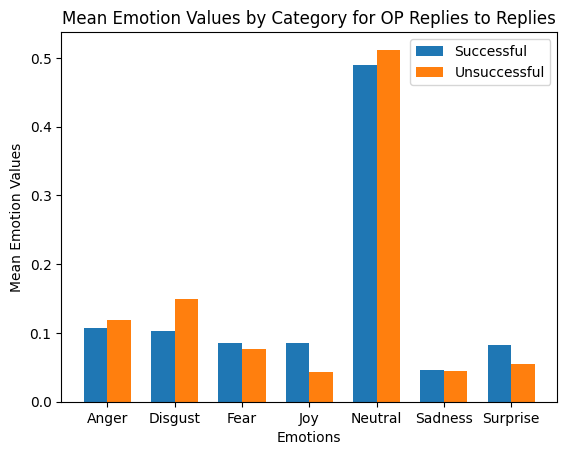

In [32]:
# each variable below is a dictionary that will have "successful" and "unsuccessful"
# keys, each with the mean emotion for each category of replies as the value
mean_anger = {}
mean_disgust = {}
mean_fear = {}
mean_joy = {}
mean_neutral = {}
mean_sadness = {}
mean_surprise = {}

mean_emotions = [mean_anger, mean_disgust, mean_fear, mean_joy, mean_neutral, mean_sadness, mean_surprise]

# get the sum of the emotion scores for both successful and unsuccessful replies
num_success = 0
num_unsuccess = 0
for op_reply in op_replies:
  if op_reply.meta['success']:
    num_success += 1
    for i in range(len(mean_emotions)):
      mean_emotions[i]['successful'] = mean_emotions[i].get('successful', 0) + op_reply_emotions[op_reply.id][i]['score']
  else:
    num_unsuccess += 1
    for i in range(len(mean_emotions)):
      mean_emotions[i]['unsuccessful'] = mean_emotions[i].get('unsuccessful', 0) + op_reply_emotions[op_reply.id][i]['score']

# divide by the total number of successful and unsuccessful replies to find 
# the mean of each emotion
for mean_emotion in mean_emotions:
  mean_emotion['successful'] /= num_success
  mean_emotion['unsuccessful'] /= num_unsuccess

# data visualizations using the mean emotions
emotions = ['Anger', 'Disgust', 'Fear', 'Joy', 'Neutral', 'Sadness', 'Surprise']
categories = ['successful', 'unsuccessful']

# Extract mean emotion values for each category
successful_values = [mean_emotion['successful'] for mean_emotion in mean_emotions]
unsuccessful_values = [mean_emotion['unsuccessful'] for mean_emotion in mean_emotions]

# Set the positions of the bars on the x-axis
bar_width = 0.35
index = np.arange(len(emotions))

# Plot the bar graph
plt.bar(index, successful_values, bar_width, label='Successful')
plt.bar(index + bar_width, unsuccessful_values, bar_width, label='Unsuccessful')

# Customize the graph
plt.xlabel('Emotions')
plt.ylabel('Mean Emotion Values')
plt.title('Mean Emotion Values by Category for OP Replies to Replies')
plt.xticks(index + bar_width/2, emotions)
plt.legend()

plt.show()

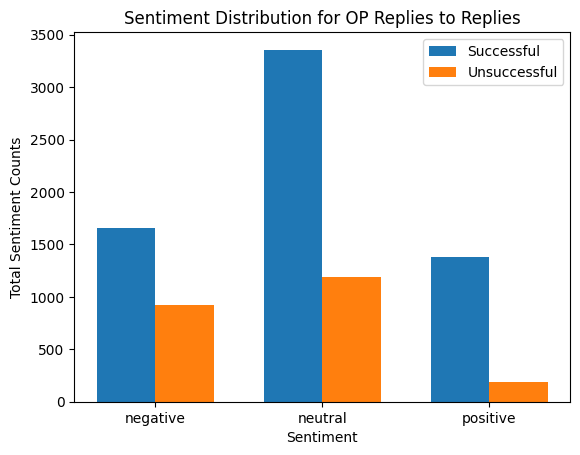

In [31]:
# find the sentiment distribution for op replies to replies

successful_sentiment_counts = [0, 0, 0]
unsuccessful_sentiment_counts = [0, 0, 0]
for op_reply in op_replies:
  if op_reply.meta['success']:
    if op_reply_sentiments[op_reply.id]['label'] == 'negative':
      successful_sentiment_counts[0] += 1
    elif op_reply_sentiments[op_reply.id]['label'] == 'neutral':
      successful_sentiment_counts[1] += 1
    else:
      successful_sentiment_counts[2] += 1
  else:
    if op_reply_sentiments[op_reply.id]['label'] == 'negative':
      unsuccessful_sentiment_counts[0] += 1
    elif op_reply_sentiments[op_reply.id]['label'] == 'neutral':
      unsuccessful_sentiment_counts[1] += 1
    else:
      unsuccessful_sentiment_counts[2] += 1

sentiments = ['negative', 'neutral', 'positive']

# data visualizations using the sentiment counts

# Set the positions of the bars on the x-axis
bar_width = 0.35
index = np.arange(len(sentiments))

# Plot the bar graph
plt.bar(index, successful_sentiment_counts, bar_width, label='Successful')
plt.bar(index + bar_width, unsuccessful_sentiment_counts, bar_width, label='Unsuccessful')

# Customize the graph
plt.xlabel('Sentiment')
plt.ylabel('Total Sentiment Counts')
plt.title('Sentiment Distribution for OP Replies to Replies')
plt.xticks(index + bar_width/2, sentiments)
plt.legend()

plt.show()

### Train a logistic regression model to evaluate baseline performance using number of words as a feature.

In [33]:
# find baseline performance based on number of words

# add num_words attribute to each reply object
for index, reply in enumerate(replies):
  num_words = len((reply.text).split())
  replies[index].num_words = num_words

# get inputs and outputs and do stratified splits to get train and test data
X = np.array([[reply.num_words, 0] for reply in replies])
y = np.array([reply.meta['success'] for reply in replies])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)


# train logistic regression model using only the number of words as a feature
model = LogisticRegression().fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = model.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.5428923459024192, Recall: 0.5351921534760348, F1-score: 0.5221719709430155


### Train a logistic regression model to evaluate performance using emotion as features


In [35]:
# keep the same y as the baseline models, but add emotion and sentiment as features
# for the input

# there are k features of the input
k = len(reply_emotions[replies[0].id])
y = np.array([reply.meta['success'] for reply in replies])
X = np.zeros((y.shape[0], k))
for i, reply in enumerate(replies):
  for j in range(k):
    # set the jth entry of the ith input example to be the score from reply_emotions
    X[i][j] = reply_emotions[reply.id][j]['score']
  
# get inputs and outputs and do stratified splits to get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# train MLP model using only sentiment as a feature
model = LogisticRegression().fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = model.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.5412935323383085, Recall: 0.5044131659095163, F1-score: 0.3817986818430368


### Train a logistic regression model to evaluate performance using sentiment as features

In [36]:
# keep the same y as the baseline models, but add emotion and sentiment as features
# for the input

# the input is a one-hot encoded vector with entries for negative, neutral and positive
# sentiment
y = np.array([reply.meta['success'] for reply in replies])
X = np.zeros((y.shape[0], 3))
for i, reply in enumerate(replies):
  if reply_sentiments[reply.id]['label'] == 'negative':
    X[i][0] = 1
  elif reply_sentiments[reply.id]['label'] == 'neutral':
    X[i][1] = 1
  else:
    X[i][2] = 1

# get inputs and outputs and do stratified splits to get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# train MLP model using only sentiment as a feature
model =  LogisticRegression().fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = model.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.2736842105263158, Recall: 0.5, F1-score: 0.3537414965986395


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


### Train a logistic regression model to evaluate performance using emotion and sentiment as features

In [37]:
# keep the same y as the baseline models, but add emotion and sentiment as features
# for the input

# there are k features of the input
k = len(reply_emotions[replies[0].id])
y = np.array([reply.meta['success'] for reply in replies])
X = np.zeros((y.shape[0], k + 3))
for i, reply in enumerate(replies):
  for j in range(k):
    # set the jth entry of the ith input example to be the score from reply_emotions
    X[i][j] = reply_emotions[reply.id][j]['score']
  if reply_sentiments[reply.id]['label'] == 'negative':
    X[i][k] = 1
  elif reply_sentiments[reply.id]['label'] == 'neutral':
    X[i][k + 1] = 1
  else:
    X[i][k + 2] = 1

# get inputs and outputs and do stratified splits to get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# train MLP model using only sentiment as a feature
model = LogisticRegression().fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = model.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.5205753353973168, Recall: 0.50483468015545, F1-score: 0.40650131599446854


### Train a multi-layer perceptron (MLP) using number of words as a feature to establish a baseline performance level for MLPs in predicting persuasiveness.

In [38]:
# find baseline performance based on number of words

# add num_words attribute to each reply object
for index, reply in enumerate(replies):
  num_words = len((reply.text).split())
  replies[index].num_words = num_words

# get inputs and outputs and do stratified splits to get train and test data
X = np.array([[reply.num_words, 0] for reply in replies])
y = np.array([reply.meta['success'] for reply in replies])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# train MLP model using only the number of words as a feature
model = MLPClassifier(max_iter=300, early_stopping=True).fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = model.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.5561228459174544, Recall: 0.5291545863919561, F1-score: 0.48058045041139963


### Train a multi-layer perceptron (MLP) using combinations of emotion and sentiment as features to see what has the most predictive power when it comes to persuasiveness.

First, we only use emotions as the inputs

In [39]:
# keep the same y as the baseline models, but add emotion and sentiment as features
# for the input

# there are k features of the input
k = len(reply_emotions[replies[0].id])
y = np.array([reply.meta['success'] for reply in replies])
X = np.zeros((y.shape[0], k))
for i, reply in enumerate(replies):
  for j in range(k):
    # set the jth entry of the ith input example to be the score from reply_emotions
    X[i][j] = reply_emotions[reply.id][j]['score']
  
# get inputs and outputs and do stratified splits to get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# train MLP model using only sentiment as a feature
model = MLPClassifier(hidden_layer_sizes=(10, 8, 6), alpha=0.0001, max_iter=100, early_stopping=True).fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = model.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.5208557936347507, Recall: 0.5039497834890171, F1-score: 0.39693197515263423


In [40]:
y_pred[:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

Now, try using sentiment as the input

In [41]:
# keep the same y as the baseline models, but add emotion and sentiment as features
# for the input

# the input is a one-hot encoded vector with entries for negative, neutral and positive
# sentiment
y = np.array([reply.meta['success'] for reply in replies])
X = np.zeros((y.shape[0], 3))
for i, reply in enumerate(replies):
  if reply_sentiments[reply.id]['label'] == 'negative':
    X[i][0] = 1
  elif reply_sentiments[reply.id]['label'] == 'neutral':
    X[i][1] = 1
  else:
    X[i][2] = 1

# get inputs and outputs and do stratified splits to get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# train MLP model using only sentiment as a feature
model = MLPClassifier(hidden_layer_sizes=(10, 6, 4), alpha=0.0001, max_iter=100, early_stopping=True).fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = model.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.273502722323049, Recall: 0.5, F1-score: 0.35358986391365554


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [42]:
y_pred[:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Finally, combine emotion and sentiment as the inputs

In [43]:
# keep the same y as the baseline models, but add emotion and sentiment as features
# for the input

# there are k features of the input
k = len(reply_emotions[replies[0].id])
y = np.array([reply.meta['success'] for reply in replies])
X = np.zeros((y.shape[0], k + 3))
for i, reply in enumerate(replies):
  for j in range(k):
    # set the jth entry of the ith input example to be the score from reply_emotions
    X[i][j] = reply_emotions[reply.id][j]['score']
  if reply_sentiments[reply.id]['label'] == 'negative':
    X[i][k] = 1
  elif reply_sentiments[reply.id]['label'] == 'neutral':
    X[i][k + 1] = 1
  else:
    X[i][k + 2] = 1

# get inputs and outputs and do stratified splits to get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# train MLP model using only sentiment as a feature
model = MLPClassifier(hidden_layer_sizes=(20, 10, 5), alpha=0.0001, max_iter=100, early_stopping=True).fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = model.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.49648901522995537, Recall: 0.4994050201623194, F1-score: 0.38718694153796


Now optimize the hyperparameters of the multi-layer perceptron model to see what the optimal precision, recall, and f1-scores are.

In [ ]:
# optimize the hyperparameters
parameter_space = {
    'hidden_layer_sizes': [
        (random.randint(2**5, 2**11), random.randint(2**5, 2**11)),
        (random.randint(2**5, 2**11), random.randint(2**5, 2**11)),
        (random.randint(2**5, 2**11), random.randint(2**5, 2**11))
    ],
    'alpha': [0.0001, 0.001, 0.01],
}

# fit 5 folds for each of 5 hyperparameter combinations, totalling 25 fits
cvFold = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
randomSearch = RandomizedSearchCV(estimator=model, n_iter=5,
	cv=cvFold, param_distributions=parameter_space,
	scoring='f1_macro')

"""
searchResults = randomSearch.fit(X_train, y_train)

# print the optimal hyperparameters
print(searchResults.best_params_)

# extract the best model and evaluate it
print('[INFO] evaluating...')
bestModel = searchResults.best_estimator_

# get the precision, recall, and f1-score using the test set
y_pred = bestModel.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print('Precision: {}, Recall: {}, F1-score: {}'.format(*scores))
"""

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.


{'hidden_layer_sizes': (372, 265), 'alpha': 0.01}
[INFO] evaluating...
Precision: 0.2732727272727273, Recall: 0.498342175066313, F1-score: 0.35298262094880223


In [ ]:
print(y_pred[:100])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]


### Train an SVM to do classification using only number of words as a feature


In [44]:
# find baseline performance based on number of words

# add num_words attribute to each reply object
for index, reply in enumerate(replies):
  num_words = len((reply.text).split())
  replies[index].num_words = num_words

# get inputs and outputs and do stratified splits to get train and test data
X = np.array([[reply.num_words, 0] for reply in replies])
y = np.array([reply.meta['success'] for reply in replies])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = clf.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.5589548706956463, Recall: 0.5545848497933502, F1-score: 0.5513402956702873


### Train SVM to do classification using only emotion as a feature

In [45]:
# keep the same y as the baseline models, but add emotion and sentiment as features
# for the input

# there are k features of the input
k = len(reply_emotions[replies[0].id])
y = np.array([reply.meta['success'] for reply in replies])
X = np.zeros((y.shape[0], k))
for i, reply in enumerate(replies):
  for j in range(k):
    # set the jth entry of the ith input example to be the score from reply_emotions
    X[i][j] = reply_emotions[reply.id][j]['score']
  
# get inputs and outputs and do stratified splits to get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# train SVM model using only sentiment as a feature
model = svm.SVC().fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = model.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.5144139449975241, Recall: 0.50207420887052, F1-score: 0.385998761132041


### Train SVM to do classification using sentiment as features

In [46]:
# keep the same y as the baseline models, but add emotion and sentiment as features
# for the input

# the input is a one-hot encoded vector with entries for negative, neutral and positive
# sentiment
y = np.array([reply.meta['success'] for reply in replies])
X = np.zeros((y.shape[0], 3))
for i, reply in enumerate(replies):
  if reply_sentiments[reply.id]['label'] == 'negative':
    X[i][0] = 1
  elif reply_sentiments[reply.id]['label'] == 'neutral':
    X[i][1] = 1
  else:
    X[i][2] = 1

# get inputs and outputs and do stratified splits to get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# train SVM model using only sentiment as a feature
model = svm.SVC().fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = model.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.2736842105263158, Recall: 0.5, F1-score: 0.3537414965986395


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


### Train SVM to do classification using both emotion and sentiment as features

In [47]:
# keep the same y as the baseline models, but add emotion and sentiment as features
# for the input

# there are k features of the input
k = len(reply_emotions[replies[0].id])
y = np.array([reply.meta['success'] for reply in replies])
X = np.zeros((y.shape[0], k + 3))
for i, reply in enumerate(replies):
  for j in range(k):
    # set the jth entry of the ith input example to be the score from reply_emotions
    X[i][j] = reply_emotions[reply.id][j]['score']
  if reply_sentiments[reply.id]['label'] == 'negative':
    X[i][k] = 1
  elif reply_sentiments[reply.id]['label'] == 'neutral':
    X[i][k + 1] = 1
  else:
    X[i][k + 2] = 1

# get inputs and outputs and do stratified splits to get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# train MLP model using only sentiment as a feature
model = svm.SVC().fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = model.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.5434752851711027, Recall: 0.5075994185255134, F1-score: 0.3990520591095123


### Train Decision tree to do classification using number of words as a feature


In [48]:
# find baseline performance based on number of words

# add num_words attribute to each reply object
for index, reply in enumerate(replies):
  num_words = len((reply.text).split())
  replies[index].num_words = num_words

# get inputs and outputs and do stratified splits to get train and test data
X = np.array([[reply.num_words, 0] for reply in replies])
y = np.array([reply.meta['success'] for reply in replies])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = clf.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.524162578467057, Recall: 0.5243548270464329, F1-score: 0.5237334700449352


### Train Decision Tree to do classification using emotion as feature


In [49]:
# keep the same y as the baseline models, but add emotion and sentiment as features
# for the input

# there are k features of the input
k = len(reply_emotions[replies[0].id])
y = np.array([reply.meta['success'] for reply in replies])
X = np.zeros((y.shape[0], k))
for i, reply in enumerate(replies):
  for j in range(k):
    # set the jth entry of the ith input example to be the score from reply_emotions
    X[i][j] = reply_emotions[reply.id][j]['score']
  
# get inputs and outputs and do stratified splits to get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# train SVM model using only sentiment as a feature
model = tree.DecisionTreeClassifier().fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = model.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.5140678279675532, Recall: 0.5140697577969475, F1-score: 0.5140687244873071


### Train Decision Tree to do Classification using sentiment as feature

In [50]:
# keep the same y as the baseline models, but add emotion and sentiment as features
# for the input

# the input is a one-hot encoded vector with entries for negative, neutral and positive
# sentiment
y = np.array([reply.meta['success'] for reply in replies])
X = np.zeros((y.shape[0], 3))
for i, reply in enumerate(replies):
  if reply_sentiments[reply.id]['label'] == 'negative':
    X[i][0] = 1
  elif reply_sentiments[reply.id]['label'] == 'neutral':
    X[i][1] = 1
  else:
    X[i][2] = 1

# get inputs and outputs and do stratified splits to get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# train SVM model using only sentiment as a feature
model = tree.DecisionTreeClassifier().fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = model.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.2736842105263158, Recall: 0.5, F1-score: 0.3537414965986395


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


### Train Decision Tree to do Classification using emotion and sentiment as features

In [51]:
# keep the same y as the baseline models, but add emotion and sentiment as features
# for the input

# there are k features of the input
k = len(reply_emotions[replies[0].id])
y = np.array([reply.meta['success'] for reply in replies])
X = np.zeros((y.shape[0], k + 3))
for i, reply in enumerate(replies):
  for j in range(k):
    # set the jth entry of the ith input example to be the score from reply_emotions
    X[i][j] = reply_emotions[reply.id][j]['score']
  if reply_sentiments[reply.id]['label'] == 'negative':
    X[i][k] = 1
  elif reply_sentiments[reply.id]['label'] == 'neutral':
    X[i][k + 1] = 1
  else:
    X[i][k + 2] = 1

# get inputs and outputs and do stratified splits to get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# train MLP model using only sentiment as a feature
model = tree.DecisionTreeClassifier().fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = model.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.4994169916770536, Recall: 0.4994139781629758, F1-score: 0.49928142186866376


### Train Adaboost Classifier to do Classification using number of words as feature


In [52]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

# find baseline performance based on number of words

# add num_words attribute to each reply object
for index, reply in enumerate(replies):
  num_words = len((reply.text).split())
  replies[index].num_words = num_words

# get inputs and outputs and do stratified splits to get train and test data
X = np.array([[reply.num_words, 0] for reply in replies])
y = np.array([reply.meta['success'] for reply in replies])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)


clf = AdaBoostClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = clf.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.5735400775941645, Recall: 0.5676161248534946, F1-score: 0.5643250475789547


### Train Adaboost Classifier to do Classification using emotion as features 


In [53]:
# keep the same y as the baseline models, but add emotion and sentiment as features
# for the input

# there are k features of the input
k = len(reply_emotions[replies[0].id])
y = np.array([reply.meta['success'] for reply in replies])
X = np.zeros((y.shape[0], k))
for i, reply in enumerate(replies):
  for j in range(k):
    # set the jth entry of the ith input example to be the score from reply_emotions
    X[i][j] = reply_emotions[reply.id][j]['score']
  
# get inputs and outputs and do stratified splits to get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# train SVM model using only sentiment as a feature
model = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = model.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.5192733976250125, Recall: 0.512715131700697, F1-score: 0.47978117527456


### Train Adaboost Classifier to do Classification using sentiment as features

In [54]:
# keep the same y as the baseline models, but add emotion and sentiment as features
# for the input

# the input is a one-hot encoded vector with entries for negative, neutral and positive
# sentiment
y = np.array([reply.meta['success'] for reply in replies])
X = np.zeros((y.shape[0], 3))
for i, reply in enumerate(replies):
  if reply_sentiments[reply.id]['label'] == 'negative':
    X[i][0] = 1
  elif reply_sentiments[reply.id]['label'] == 'neutral':
    X[i][1] = 1
  else:
    X[i][2] = 1

# get inputs and outputs and do stratified splits to get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# train SVM model using only sentiment as a feature
model = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = model.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.2736842105263158, Recall: 0.5, F1-score: 0.3537414965986395


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


### Train Adaboost Classifier to do Classification using emotion and sentiment as features

In [55]:
# keep the same y as the baseline models, but add emotion and sentiment as features
# for the input

# there are k features of the input
k = len(reply_emotions[replies[0].id])
y = np.array([reply.meta['success'] for reply in replies])
X = np.zeros((y.shape[0], k + 3))
for i, reply in enumerate(replies):
  for j in range(k):
    # set the jth entry of the ith input example to be the score from reply_emotions
    X[i][j] = reply_emotions[reply.id][j]['score']
  if reply_sentiments[reply.id]['label'] == 'negative':
    X[i][k] = 1
  elif reply_sentiments[reply.id]['label'] == 'neutral':
    X[i][k + 1] = 1
  else:
    X[i][k + 2] = 1

# get inputs and outputs and do stratified splits to get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# train MLP model using only sentiment as a feature
model = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)

# get the precision, recall, and f1-score using the test set
y_pred = model.predict(X_test)
scores = precision_recall_fscore_support(y_test, y_pred, average='macro')[0:3]
print("Precision: {}, Recall: {}, F1-score: {}".format(*scores))

Precision: 0.51764456997793, Recall: 0.5114859289129362, F1-score: 0.4772213935648838
